In [11]:
import pandas as pd
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.linear_model import Ridge
from tabulate import tabulate
import mlflow
from sklearn.linear_model import SGDRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

path = 'SAMPLE_DATA_SET.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])


INPUT DATA

In [12]:
X =df.get(0)
X = (X.iloc[:,1:]).values
X = X.T
print(X.shape)

(839, 444)


OUTPUT DATA

In [13]:
Y =df.get(1)
Y = (Y.iloc[:,:]).values
print(Y.shape)

(839, 2)


RIDGE REGRESSION with closed form solution

Param 1
0.05 ripartition
0.1 ripartition
0.15 ripartition
0.2 ripartition
0.25 ripartition
0.3 ripartition
0.35 ripartition
0.4 ripartition
0.45 ripartition
0.5 ripartition
╔════╦════════════════╦══════════════╦══════════════╦══════════════╦══════════════╦═════════════╦═════════════╦════════════╦═════════════╦═════════╦═════════╗
║    ║   Test size(%) ║   Best(MSE1) ║   Best(MSE2) ║   Mean(MSE1) ║   Mean(MSE2) ║   Var(MSE1) ║   Var(MSE2) ║     alpha1 ║      alpha2 ║   seed1 ║   seed2 ║
╠════╬════════════════╬══════════════╬══════════════╬══════════════╬══════════════╬═════════════╬═════════════╬════════════╬═════════════╬═════════╬═════════╣
║  5 ║        1.0725  ║     0.777158 ║      1.83534 ║      2.19272 ║    0.213925  ║   0.417019  ║   0.417019  ║ 0.00915723 ║ 0.0020759   ║      33 ║      87 ║
║ 10 ║        1.24937 ║     1.39209  ║      1.83322 ║      2.14331 ║    0.0997148 ║   0.183104  ║   0.183104  ║ 0.00913822 ║ 0.000553081 ║      52 ║      47 ║
║ 15 ║        1.33195 ║     1.36

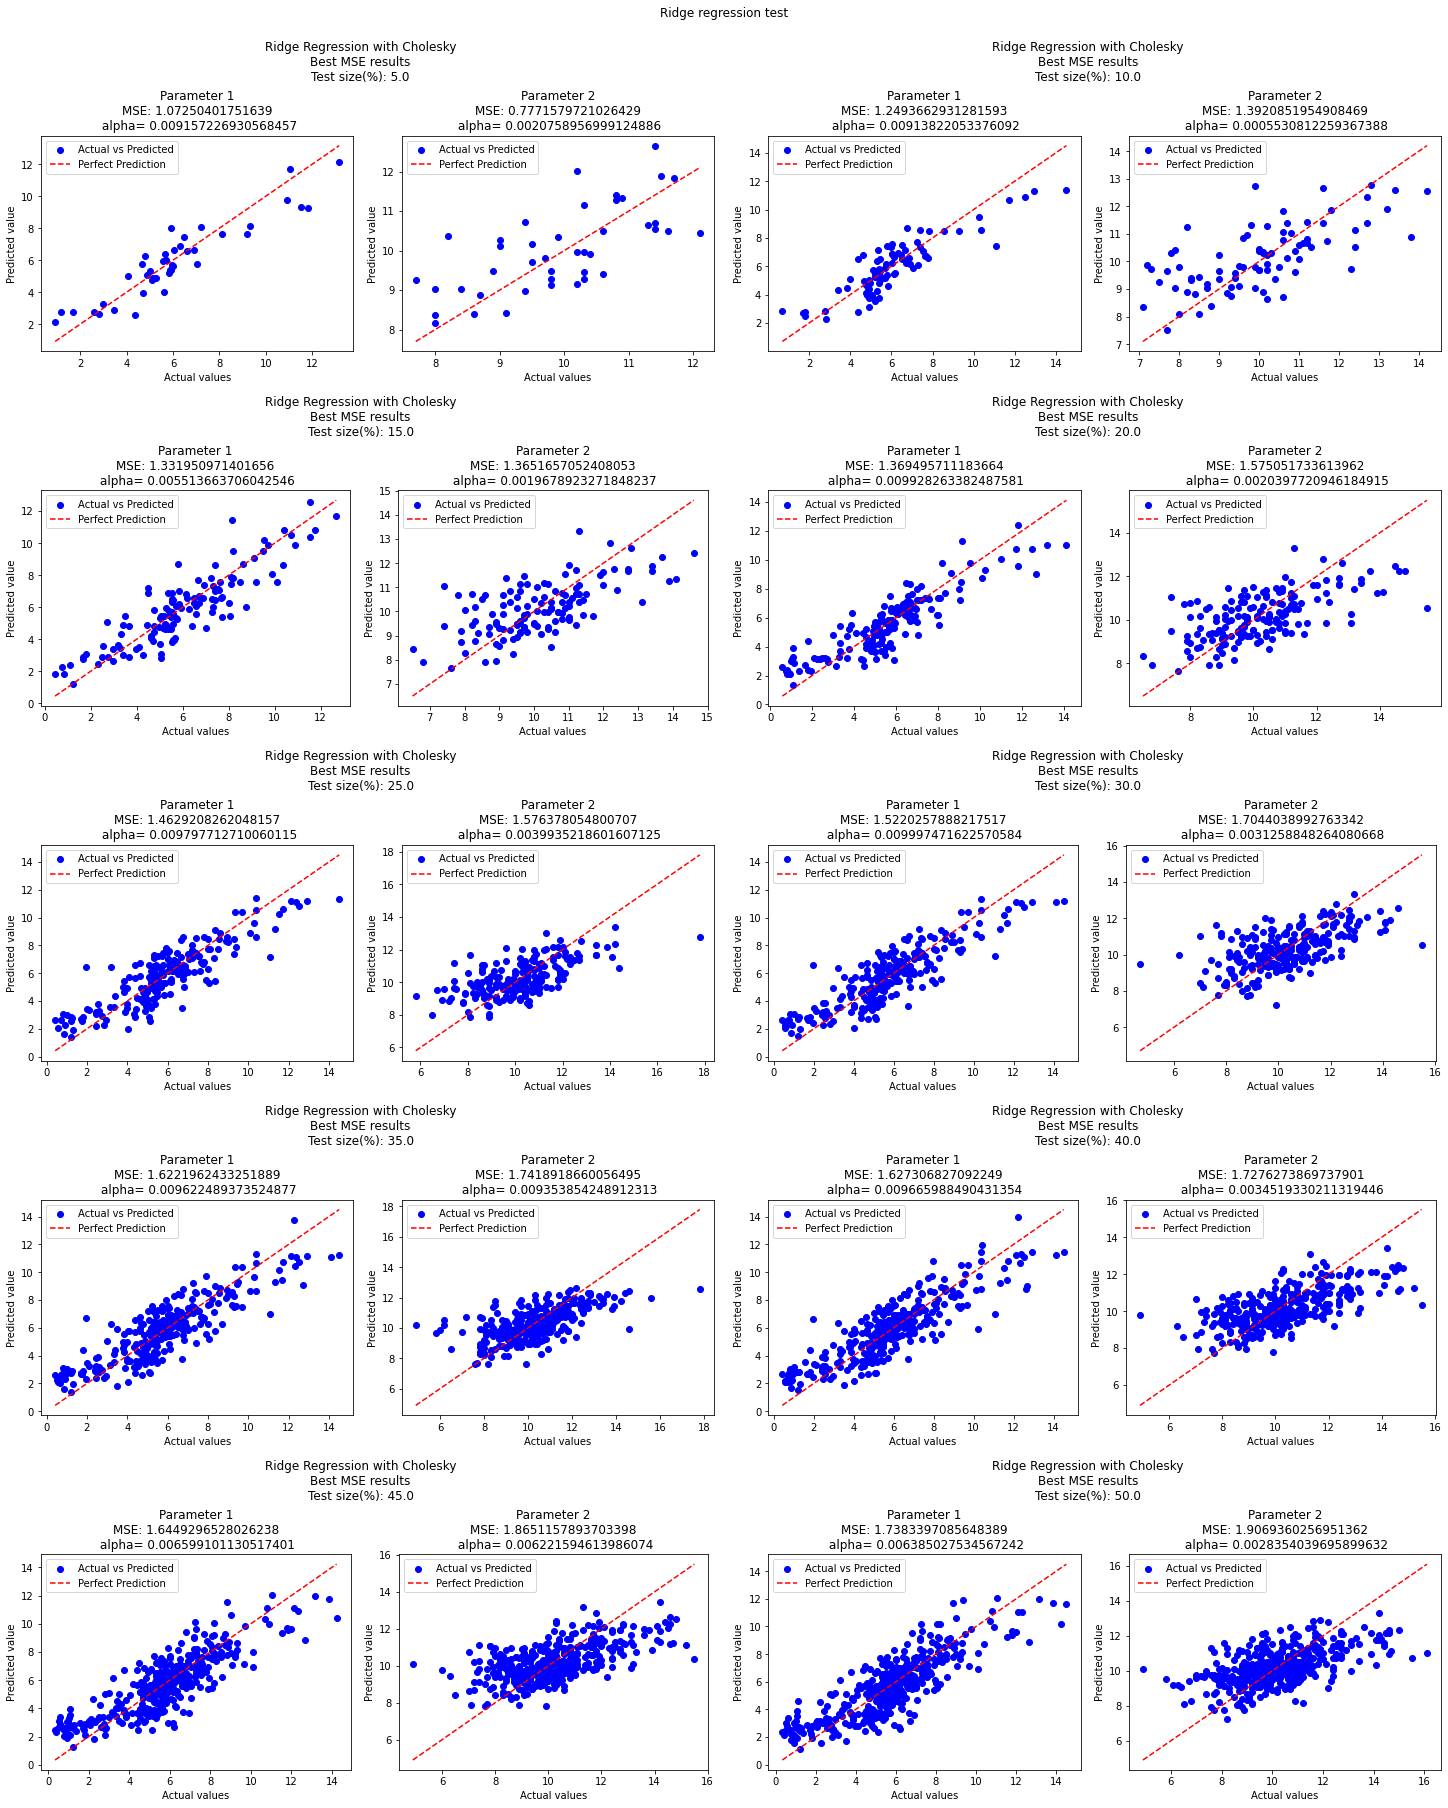

In [20]:
mlflow.set_experiment("Ridge Cholesky")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = []  

# create 5x2 subfigs
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
fig.suptitle('Ridge regression test' + "\n")
subfigs = fig.subfigures(nrows=5, ncols=2).flatten()
k = 0

print("Param 1")
for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_cl = Ridge(solver="cholesky")
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_cl,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_cl
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
        
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        mlflow.log_metric("alpha1", best_data_1["alpha"])
    
    
        '''PARAM 2'''
        MSE_param2 = []
    
        best_MSE_2 = 100000000
        best_data_2 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}
    
        i = 0
        for i in range(trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
            param_grid = param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_cl = Ridge(solver="cholesky")
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_cl,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.predict(X_test)
            #save MSE of the second parameters
            MSE_param2.append(mean_squared_error(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if MSE_param2[-1] < best_MSE_2:
              best_MSE_2 = MSE_param2[-1]
              best_data_2["Y_test"] = Y_test
              best_data_2["Y_pred"] = Y_pred_ridge_cl
              best_data_2["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_2["seed"] = seeds[i]


        mlflow.log_metric("Best_MSE2", best_MSE_2)
        mlflow.log_metric("Mean_MSE2", np.mean(MSE_param2))
        mlflow.log_metric("Var_MSE2", np.var(MSE_param2))
        mlflow.log_metric("alpha2", best_data_2["alpha"])


    results.append([str(ripartition *100 ), str(best_MSE_1), str(best_MSE_2),
                    (np.mean(MSE_param1)),str(np.mean(MSE_param2)), str(np.var(MSE_param1)),
                    str(np.var(MSE_param2)), str(np.var(MSE_param2)), str(best_data_1["alpha"]), str(best_data_2["alpha"]),
                   best_data_1["seed"],best_data_2["seed"]])

    '''PLOT THE BEST MODELS'''
    subfigs[k].suptitle(
        "Ridge Regression with Cholesky" + "\n" + "Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    # create 1x2 subplots per subfig
    axs = subfigs[k].subplots(nrows=1, ncols=2)
    axs[0].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[0].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[0].legend()
    axs[0].set_xlabel("Actual values")
    axs[0].set_ylabel("Predicted value")
    axs[0].set_title(
        "Parameter 1" + "\n" + "MSE: " + str(min(MSE_param1)) + "\n" + " alpha= " + str(best_data_1["alpha"]))

    axs[1].scatter(best_data_2["Y_test"], best_data_2["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[1].plot([min(best_data_2["Y_test"]), max(best_data_2["Y_test"])],
                [min(best_data_2["Y_test"]), max(best_data_2["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[1].legend()
    axs[1].set_xlabel("Actual values")
    axs[1].set_ylabel("Predicted value")
    axs[1].set_title(
        "Parameter 2" + "\n" + "MSE: " + str(min(MSE_param2)) + "\n" + " alpha= " + str(best_data_2["alpha"]))
    k += 1


'''SHOW RESULTS'''
headers = ["Test size(%)","Best(MSE1)", "Best(MSE2)","Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)","alpha1","alpha2","seed1","seed2"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with SGD**

0.05 ripartition
0.1 ripartition
0.15 ripartition
0.2 ripartition
0.25 ripartition
0.3 ripartition
0.35 ripartition
0.4 ripartition
0.45 ripartition
0.5 ripartition
╔════════════════╦══════════════╦══════════════╦══════════════╦══════════════╦═════════════╦═════════════╦═════════════╦═════════════╦═════════╦═════════╗
║   Test size(%) ║   Best(MSE1) ║   Best(MSE2) ║   Mean(MSE1) ║   Mean(MSE2) ║   Var(MSE1) ║   Var(MSE2) ║      alpha1 ║      alpha2 ║   seed1 ║   seed2 ║
╠════════════════╬══════════════╬══════════════╬══════════════╬══════════════╬═════════════╬═════════════╬═════════════╬═════════════╬═════════╬═════════╣
║              5 ║      1.11965 ║      1.12395 ║      2.11279 ║      2.75628 ║   0.259846  ║   0.706654  ║ 1.13456e-05 ║ 0.000152932 ║      21 ║      87 ║
║             10 ║      1.38713 ║      1.6014  ║      2.13928 ║      2.70027 ║   0.14091   ║   0.269621  ║ 0.00220103  ║ 5.40324e-05 ║      34 ║      86 ║
║             15 ║      1.49036 ║      1.8293  ║      2.1852

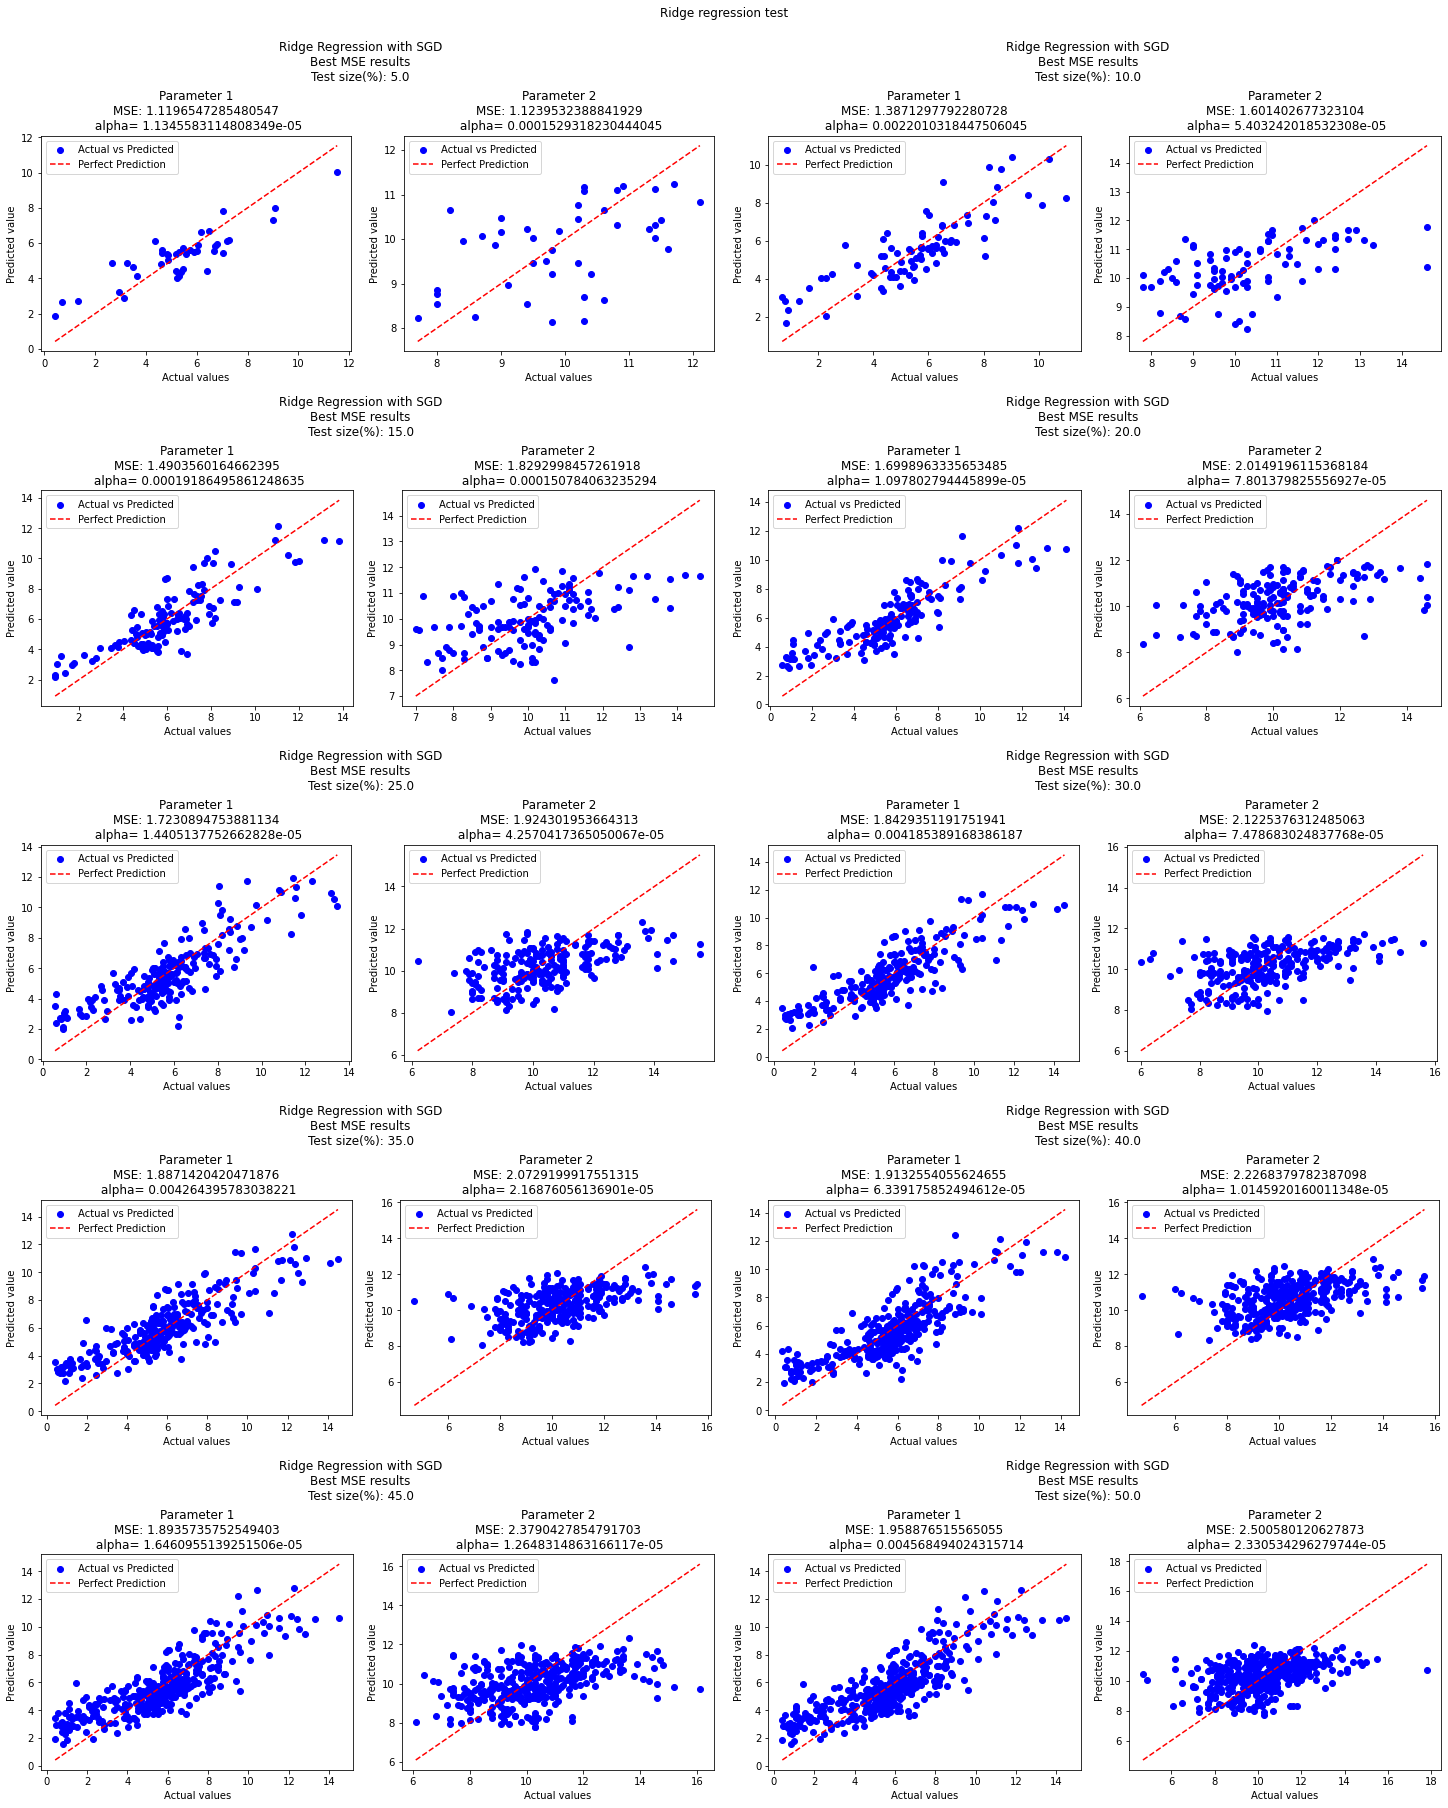

In [24]:
mlflow.set_experiment("Ridge SGD")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
from sklearn.linear_model import SGDRegressor
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = [] 

# create 5x2 subfigs
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
fig.suptitle('Ridge regression test' + "\n")
subfigs = fig.subfigures(nrows=5, ncols=2).flatten()
k = 0

for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_sgd
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
    
    
        '''PARAM 2'''
        MSE_param2 = []
    
        best_MSE_2 = 100000000
        best_data_2 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}
    
        i = 0
        for i in range(trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the second parameters
            MSE_param2.append(mean_squared_error(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param2[-1] < best_MSE_2:
              best_MSE_2 = MSE_param2[-1]
              best_data_2["Y_test"] = Y_test
              best_data_2["Y_pred"] = Y_pred_ridge_sgd
              best_data_2["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_2["seed"] = seeds[i]


        mlflow.log_metric("Best_MSE2", best_MSE_2)
        mlflow.log_metric("Mean_MSE2", np.mean(MSE_param2))
        mlflow.log_metric("Var_MSE2", np.var(MSE_param2))
        mlflow.log_metric("alpha2", best_data_2["alpha"])

    results.append([str(ripartition *100 ), str(best_MSE_1), str(best_MSE_2),
     (np.mean(MSE_param1)),str(np.mean(MSE_param2)), str(np.var(MSE_param1)), 
                    str(np.var(MSE_param2)),str(best_data_1["alpha"]),str(best_data_2["alpha"]),
                    best_data_1["seed"],best_data_2["seed"]])

    '''PLOT THE BEST MODELS'''
    subfigs[k].suptitle(
        "Ridge Regression with SGD" + "\n" + "Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    # create 1x2 subplots per subfig
    axs = subfigs[k].subplots(nrows=1, ncols=2)
    axs[0].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[0].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[0].legend()
    axs[0].set_xlabel("Actual values")
    axs[0].set_ylabel("Predicted value")
    axs[0].set_title(
        "Parameter 1" + "\n" + "MSE: " + str(min(MSE_param1)) + "\n" + " alpha= " + str(best_data_1["alpha"]))

    axs[1].scatter(best_data_2["Y_test"], best_data_2["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[1].plot([min(best_data_2["Y_test"]), max(best_data_2["Y_test"])],
                [min(best_data_2["Y_test"]), max(best_data_2["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[1].legend()
    axs[1].set_xlabel("Actual values")
    axs[1].set_ylabel("Predicted value")
    axs[1].set_title(
        "Parameter 2" + "\n" + "MSE: " + str(min(MSE_param2)) + "\n" + " alpha= " + str(best_data_2["alpha"]))
    k += 1


'''SHOW RESULTS'''
headers = ["Test size(%)","Best(MSE1)", "Best(MSE2)","Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)","alpha1","alpha2","seed1","seed2"]

print(tabulate(results, headers,  tablefmt="double_outline"))

